# Validation of different classification models based on Titanic survival dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, f1_score, r2_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
titanic = pd.read_csv(r'TitanicSurvival.csv')
titanic.head()

,Unnamed: 0,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


In [3]:
titanic.columns = ["Name", "Survived", "Sex", "Age", "Class"]

In [4]:
titanic.loc[titanic["Sex"]=="male", "Sex"] = 0
titanic.loc[titanic["Sex"]=="female", "Sex"] = 1

titanic.loc[titanic["Survived"]=="yes", "Survived"] = 1
titanic.loc[titanic["Survived"]=="no", "Survived"] = 0

titanic.loc[titanic["Class"]=="1st", "Class"] = 1
titanic.loc[titanic["Class"]=="2nd", "Class"] = 2
titanic.loc[titanic["Class"]=="3rd", "Class"] = 3

In [5]:
titanic[["Class", "Sex"]] = titanic[["Class", "Sex"]].astype(object) 
titanic.loc[:,"Survived"] = titanic.loc[:,"Survived"].astype(int)

In [6]:
titanic.dtypes

Name         object
Survived      int32
Sex          object
Age         float64
Class        object
dtype: object

In [7]:
titanic.loc[titanic["Age"].isna()]

,Name,Survived,Sex,Age,Class
15,"Baumann, Mr. John D",0,0,NaN,1
37,"Bradley, Mr. George (George Ar",1,0,NaN,1
40,"Brewe, Dr. Arthur Jackson",0,0,NaN,1
46,"Cairns, Mr. Alexander",0,0,NaN,1
59,"Cassebeer, Mrs. Henry Arthur Jr",1,1,NaN,1
...,...,...,...,...,...
1293,"Williams, Mr. Howard Hugh Harr",0,0,NaN,3
1297,"Wiseman, Mr. Phillippe",0,0,NaN,3
1302,"Yousif, Mr. Wazli",0,0,NaN,3
1303,"Yousseff, Mr. Gerious",0,0,NaN,3


In [8]:
titanic = titanic.dropna()

In [9]:
y = titanic["Survived"]
X = titanic.drop(["Survived", "Name"], axis = 1) #dropping name because it is not a valid feature for the models

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
survived = titanic[titanic.Survived==1].shape[0]
n_survived = titanic[titanic.Survived==0].shape[0]

In [36]:
print(f'Number of people that survived the Titanic catastrophe: {survived} ({survived/(survived+n_survived)*100:.2F}%)')
print(f'Number of people that did not survive the Titanic catastrophe: {n_survived} ({n_survived/(survived+n_survived)*100:.2F}%)')

Number of people that survived the Titanic catastrophe: 427 (40.82%)
Number of people that did not survive the Titanic catastrophe: 619 (59.18%)


We can see that there is a slight class imbalance, therefore when validating the model it will be important to look at f1-score and not only the accuracy. 

## Creating the Random Forest model

In [23]:
model_rf  = RandomForestClassifier(n_estimators = 100) 
model_rf.fit(X_train, y_train)
accuracy = model_rf.score(X_test, y_test)
print(f'Accuracy of the Random Forest model: {accuracy*100:.2f}%')

Accuracy of the Random Forest model: 72.38%


## Model validation

**1. K-fold cross-validation**

In [13]:
standardizer = StandardScaler()
model_rf  = RandomForestClassifier(n_estimators = 100) 
pipeline = make_pipeline(standardizer, model_rf)

In [14]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

In [16]:
cv_results = cross_val_score(pipeline, 
                            X_train, 
                            y_train, 
                             cv = kf, 
                            scoring = 'accuracy', 
                            n_jobs = -1)
print(f'Mean accuracy of the Random Forest model for k-fold validation: {cv_results.mean()*100:.2f}%') 

Mean accuracy of the Random Forest model for k-fold validation: 80.26%


In [17]:
cv_results = cross_val_score(pipeline, 
                            X_train, 
                            y_train, 
                             cv = skf, 
                            scoring = 'accuracy', 
                            n_jobs = -1)
print(f'Mean accuracy of the Random Forest model for stratified k-fold validation: {cv_results.mean()*100:.2f}%') 

Mean accuracy of the Random Forest model for stratified k-fold validation: 80.02%


**2. Dummy validation**

Methods: 
- `most_frequent` -- returns the most frequent class label
- `stratified` -- the method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities and returns the class label which got probability one in the one-hot vector
- `uniform` -- generates predictions uniformly at random from the list of unique classes, i.e. each class has equal probability.
- `constant` -- always predicts a constant label that is provided by the user
- `prior` -- the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution.

In [18]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy_accuracy = dummy.score(X_test, y_test)
print(f'Accuracy of the dummy model for our data: {dummy_accuracy*100:.2f}%') 

Accuracy of the dummy model for our data: 57.14%


In [19]:
dummy = DummyClassifier(strategy = 'stratified')
dummy.fit(X_train, y_train)
dummy_accuracy = dummy.score(X_test, y_test)
print(f'Accuracy of the dummy model for our data: {dummy_accuracy*100:.2f}%') 

Accuracy of the dummy model for our data: 51.90%


We want to compare the dummy classifier to our model. The dummy gives worse results (accuracies) therefore we can assume that our model is better than a dummy classifier. 

**3. Confusion matrix**

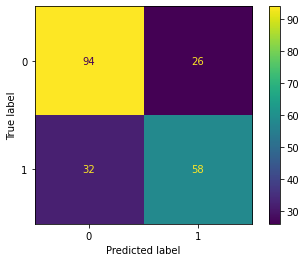

In [25]:
y_pred = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[0,1])
disp.plot()
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       120
           1       0.69      0.64      0.67        90

    accuracy                           0.72       210
   macro avg       0.72      0.71      0.72       210
weighted avg       0.72      0.72      0.72       210



Both the accuracy and the f1-score look good. 

**4. The ROC curve**

It plots the True Positive Rate (TPR), or sensitivity, against the False Positive Rate (FPR) across different threshold values for the classifier.

Different points on the ROC curve represent different thresholds used by the classifier to decide between positive and negative classes. As the threshold changes, so do the TPR and FPR.

Performance Assessment:

- Ideal Classifier: The best performance is represented by a point at the top-left corner of the plot (TPR=1, FPR=0), meaning perfect sensitivity with zero false positives.
- Random Guessing: A 45-degree diagonal line represents a random guess, where TPR = FPR. This line is the baseline for comparison. Any classifier that performs below this line is worse than random.
- AUC (Area Under the Curve): The ROC curve's area (AUC) quantifies the classifier's ability to distinguish between the two classes. An AUC of 1.0 indicates perfect classification, whereas an AUC of 0.5 indicates no better than random guessing.

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

In [41]:
model_rf.fit(X_train, y_train)
y_prob = model_rf.predict_proba(X_test)[:,1]

In [42]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)

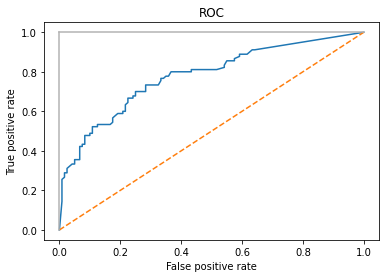

In [43]:
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '.7'), plt.plot([1, 1], c = '.7')
plt.ylabel('True positive rate')
plt.xlabel("False positive rate")
plt.show()

In [47]:
print(f'AUC (Area Under the Curve) score: {roc_auc_score(y_test, y_prob):.2f}')

AUC (Area Under the Curve) score: 0.78


**5. Y-scrambling**

It's a validation technique used primarily in machine learning and cheminformatics (especially in QSAR, Quantitative Structure-Activity Relationship modeling) to test the robustness and significance of a predictive model. The goal is to determine if a model is truly learning meaningful relationships between inputs and outputs or if it is merely capturing noise in the data.

In Y-scrambling, the response variable (Y)—the variable the model is trying to predict—is randomly shuffled, or "scrambled." This scrambling removes any real association between the input variables (X) and the response variable (Y). The model is then re-trained on this scrambled dataset. Since the true relationship between X and Y has been broken, a well-validated model should now perform poorly, with predictive power near random.

In [48]:
import random

shuffled_auc = []
y_train = np.array(y_train)

from tqdm.notebook import trange
for i in trange(100):
    np.random.shuffle(y_train)
    
    model_rf.fit(X_train, y_train)
    
    pred = model_rf.predict(X_test)
    shuffled_auc.append(accuracy_score(y_test,pred))

  0%|          | 0/100 [00:00<?, ?it/s]

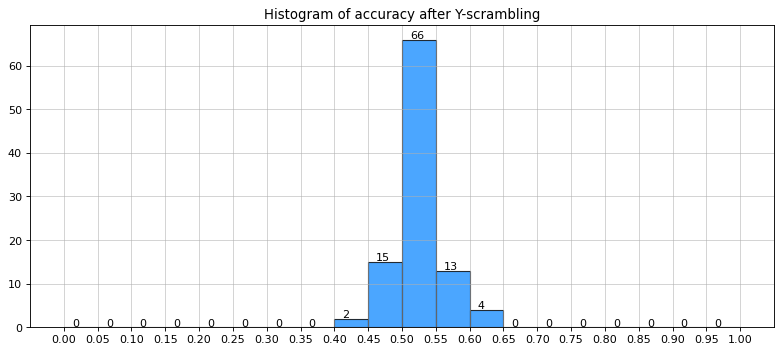

In [52]:
bins_list = np.linspace(start=0, stop=1, num=21)
fig = plt.figure(figsize=(12, 5), dpi=80)
n, bins, edges = plt.hist(shuffled_auc,
                              bins=bins_list,
                              ec="k",
                              color = "dodgerblue",
                              alpha=0.8)
plt.xticks(bins_list)
plt.grid(axis = "both", alpha = 0.6)
for a,b in zip(bins,n):
    plt.text(a+0.012, b+0.2, str(int(b)))
plt.title("Histogram of accuracy after Y-scrambling")
plt.show()

We can see that the accuracies after Y-scrambling are mostly around 50-55%, which is good because it means that the re-trained models does not see any dependencies (as they have been removed) and is as good as a coin toss.